In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [2]:
def same_padding(kernel_size):
  import math
  return math.floor((kernel_size - 1) / 2)

In [3]:
class ResidualBlock(nn.Module):
  def __init__(self, input_channel, output_channel, kernel_size = 3, padding = 0):
    super(ResidualBlock, self).__init__()
    self.input_channel = input_channel
    self.output_channel = output_channel
    self.conv1 = nn.Conv2d(input_channel, input_channel, kernel_size=kernel_size, padding=same_padding(kernel_size))
    self.conv2 = nn.Conv2d(input_channel, output_channel, kernel_size=kernel_size, padding=same_padding(kernel_size))
    self.relu = nn.ReLU()
    self.batchnorm1 = nn.BatchNorm2d(input_channel)
    self.batchnorm2 = nn.BatchNorm2d(output_channel)
    self.skip = nn.Conv2d(input_channel, output_channel, kernel_size=1)

  def forward(self, x):
    residual = x
    if self.input_channel != self.output_channel:
      residual = self.skip(residual)
    x = self.conv1(x)
    x = self.relu(x)
    x = self.batchnorm1(x)
    x = self.conv2(x)
    x = self.relu(x)
    out = x + residual
    out = self.batchnorm2(out)
    return out

In [4]:
class ResNet(nn.Module):
  def __init__(self):
    super(ResNet, self).__init__()
    self.rn1 = ResidualBlock(3, 16)
    self.rn2 = ResidualBlock(16, 32)
    self.rn3 = ResidualBlock(32, 64)
    self.rn4 = ResidualBlock(64, 128)
    self.rn5 = ResidualBlock(128, 256)
    self.rn6 = ResidualBlock(256, 128)
    self.maxpool = nn.MaxPool2d(2)
    self.flatten = nn.Flatten()
    self.linear1 = nn.Linear(2048, 128)
    self.linear2 = nn.Linear(128, 10)
    self.batchnorm1d = nn.BatchNorm1d(128)
    self.relu = nn.ReLU()
  
  def forward(self, x):
    out = self.rn1(x)
    out = self.rn2(out)
    out = self.maxpool(out)
    out = self.rn3(out)
    out = self.rn4(out)
    out = self.maxpool(out)
    out = self.rn5(out)
    out = self.maxpool(out)
    out = self.rn6(out)
    out = self.flatten(out)
    out = self.linear1(out)
    out = self.relu(out)
    out = self.batchnorm1d(out)
    out = self.linear2(out)
    
    return out


In [5]:
T = transforms.Compose([
    transforms.RandomCrop(32),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

In [6]:
cifar10_train = datasets.CIFAR10('./', download=True, transform=T)
cifar10_test = datasets.CIFAR10('./', train=False, download=True, transform=T)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
train_data_loader = DataLoader(cifar10_train, batch_size=50)
test_data_loader = DataLoader(cifar10_test, batch_size = 50)

In [8]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
RNModel = ResNet().to(device)
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimM = optim.Adam(RNModel.parameters(), lr = learning_rate)

In [9]:
epochs = 30
model_loss_track = []
RNModel.train()
for i in range(epochs):
  for index, (img, label) in enumerate(train_data_loader):
    img = img.to(device)
    label = label.to(device)

    pred = RNModel(img)
    model_loss = criterion(pred, label)

    model_loss_track.append(model_loss.item())
    optimM.zero_grad()
    model_loss.backward()
    optimM.step()
  
  if (i + 1) % 20 == 0:
    print('reduce Learning Rate')
    learning_rate /= 3
    for g in optimM.param_groups:
      g['lr'] = learning_rate

  print('Finish {} Epochs'.format(i + 1))
  print(model_loss.item())

Finish 1 Epochs
1.1423726081848145
Finish 2 Epochs
0.8933972120285034
Finish 3 Epochs
0.7016841173171997
Finish 4 Epochs
0.7514293193817139
Finish 5 Epochs
0.5716493725776672
Finish 6 Epochs
0.5023756623268127
Finish 7 Epochs
0.4475986361503601
Finish 8 Epochs
0.6350506544113159
Finish 9 Epochs
0.5998473167419434
Finish 10 Epochs
0.43190357089042664
Finish 11 Epochs
0.377203106880188
Finish 12 Epochs
0.28789687156677246
Finish 13 Epochs
0.18714188039302826
Finish 14 Epochs
0.333501935005188
Finish 15 Epochs
0.40169647336006165
Finish 16 Epochs
0.16835063695907593
Finish 17 Epochs
0.2846759855747223
Finish 18 Epochs
0.22314351797103882
Finish 19 Epochs
0.11662270873785019
reduce Learning Rate
Finish 20 Epochs
0.2442878931760788
Finish 21 Epochs
0.17545950412750244
Finish 22 Epochs
0.12623456120491028
Finish 23 Epochs
0.10121382772922516
Finish 24 Epochs
0.1242612898349762
Finish 25 Epochs
0.11607228964567184
Finish 26 Epochs
0.09912800788879395
Finish 27 Epochs
0.014952854253351688
Fini

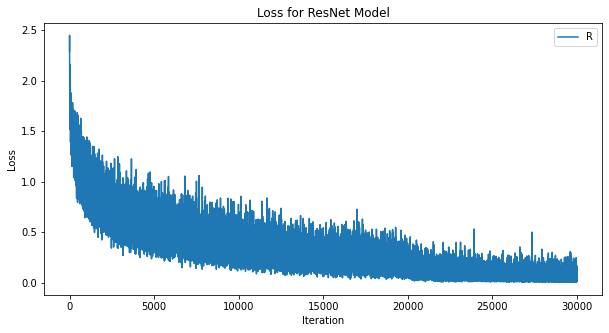

In [10]:
plt.figure(figsize=(10,5))

plt.title('Loss for ResNet Model')
plt.plot(model_loss_track, label="R")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [11]:

RNModel.eval()
with torch.no_grad():
  correct = 0
  total = 0
  for index, (images,label) in enumerate(test_data_loader):
    images = images.to(device)
    label = label.to(device)

    outputs = RNModel(images)
    


    _,predict = torch.max(outputs, 1)

    total += len(label)
    correct += (predict == label).sum().item()
  print('Accurcy of the model is {}%'.format(100 * (correct/total)))




Accurcy of the model is 86.79%
